# LNMMSB

In [1]:
import os 
import sys
import jax
import jax.numpy as jnp
from jax.nn import softmax

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils.plots import plot_roles, plot_adjacency_matrix, plot_gammas  
from utils.utils import compute_best_permutation, l1_loss

from models.LNMMSB import jitLNMMSB, LNMMSB

## Generation

Sampling new gammas


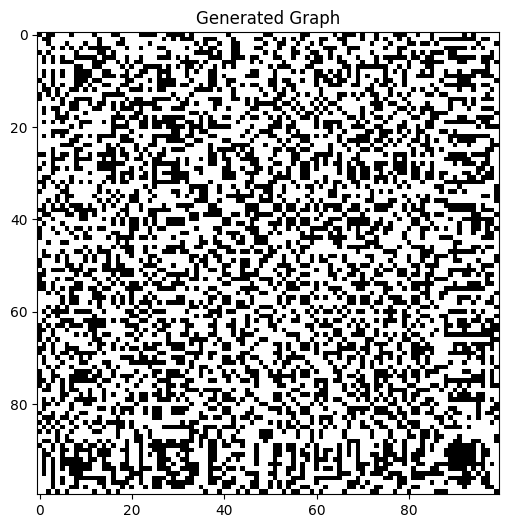

(100, 3)


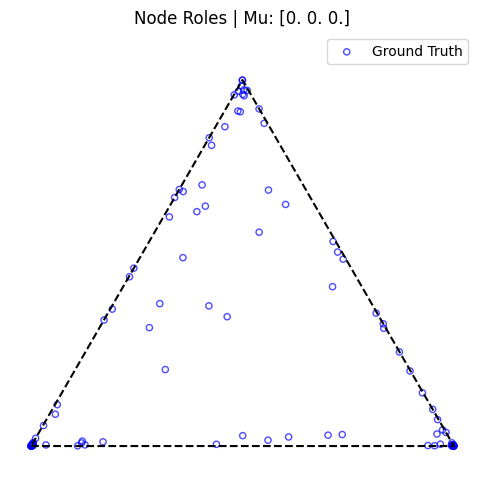

In [ ]:
N = 100
K = 3

B = jnp.array([[1, 0.3, 0],
              [0.3, 1, 0],
              [0, 0, 1]])
Sigma = jnp.eye(K-1)*20
mu = jnp.array([0, 0])


# plt.imshow(E)
# plt.show()

#print(gammas)
    
gen_model = LNMMSB(N, K, key=43, B=B, mu=mu, Sigma=Sigma)
E = gen_model.generate_graph()
plot_adjacency_matrix(E, title="Generated Graph")
expanded_gamma = jnp.concatenate([gen_model.gamma_tilde, jnp.zeros((gen_model.N, 1))], axis=-1) # shape (T,N,K)
expanded_mu = jnp.concatenate([gen_model.mu, jnp.zeros((1,))], axis=-1) # shape (,K)
pis = softmax(expanded_gamma, axis=-1)
print(pis.shape)
jnp.set_printoptions(precision=2, suppress=True)
plot_roles(pis, title=f"Ground Truth Roles | Mu: {expanded_mu}")

# Inference

In [3]:
restarts = 3

best_model = None
best_ll = -jnp.inf
for run in range(restarts):
    print(f"Run {run+1}")

    model = jitLNMMSB(nodes=100, roles=3, key=100+run)
    ll = model.fit(E, max_inner_iters=5000, max_outer_iters=150, tol=1e-6, verbose=True)

    if ll > best_ll:
        best_ll = ll
        best_model = model
    print(f"Current ll:{ll} | Best ll:{best_ll}")


Run 1
Best initialization log likelihood: -1444.4819
Current ll:-1451.5859375 | Best ll:-1451.5859375
Run 2
Best initialization log likelihood: -641.76434
Current ll:-2678.86279296875 | Best ll:-1451.5859375
Run 3
Best initialization log likelihood: -1449.6212
Current ll:-1451.587158203125 | Best ll:-1451.5859375


In [4]:
#check if sigma tilde is positive definite


### Role Matrix Recovery

In [5]:
jnp.set_printoptions(precision=3, suppress=True)
print("Best Model Role Matrix:")
print(best_model.B)
print("Ground Truth Role Matrix:")
print(B)


Best Model Role Matrix:
[[1.    0.    0.275]
 [0.    1.    0.   ]
 [0.28  0.    1.   ]]
Ground Truth Role Matrix:
[[1.  0.3 0. ]
 [0.3 1.  0. ]
 [0.  0.  1. ]]


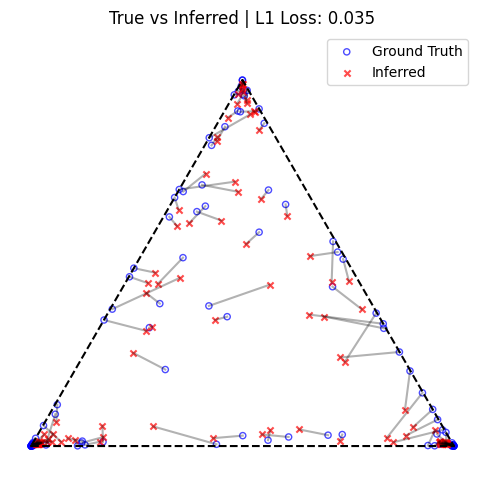

In [6]:
inferred_gammas = jnp.concatenate([best_model.gamma_tilde, jnp.zeros((best_model.N, 1))], axis=-1) # shape (N,K
true_gammas = jnp.concatenate([gen_model.gamma_tilde, jnp.zeros((model.N, 1))], axis=-1) # shape (N,K)

inferred_roles = softmax(inferred_gammas, axis=-1)
true_roles = softmax(true_gammas, axis=-1)

perm = compute_best_permutation(true_roles, inferred_roles)
plot_roles(true_roles, inferred_roles[:, perm], title=f"True vs Inferred | L1 Loss: {l1_loss(true_roles, inferred_roles[:, perm]):.3f}")

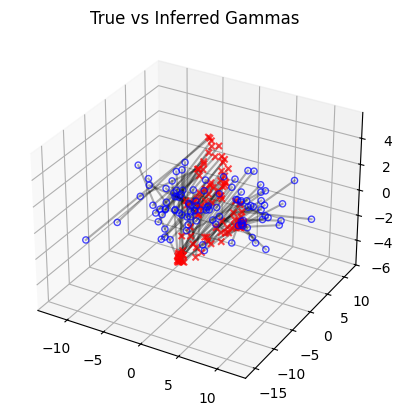

In [7]:
plot_gammas(true_gammas, inferred_gammas[:, perm], title="True vs Inferred Gammas")

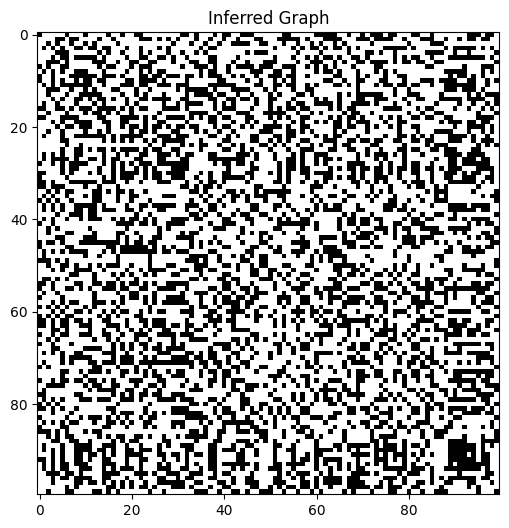

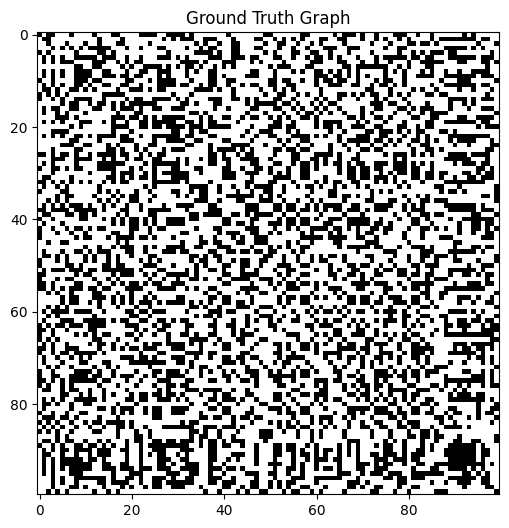

In [8]:
E_inferred = best_model.generate_graph()
plot_adjacency_matrix(E_inferred, title="Inferred Graph")
plot_adjacency_matrix(E , title="Ground Truth Graph")